# Implimentation of Collobarative Multi Agents

In [18]:
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from typing import Annotated
from langgraph.graph import StateGraph,END,START, MessagesState
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain.tools.tavily_search import TavilySearchResults
import matplotlib

In [19]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [20]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

In [21]:
@tool
def python_repl_tool(code:Annotated[str,"The python code to execute to generate your chart."]):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = PythonREPL.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [22]:
def make_system_prompt(instruction:str)->str:
    return  (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        "If user asks to generate chart then until chart is generated doint respond with FINAL ANSWER"
        f"\n{instruction}"
    )

In [23]:
def get_next_node(last_message:BaseMessage, goto:str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto


In [24]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4.1-2025-04-14")

In [25]:
from typing import Literal
from langgraph.types import Command

In [26]:
def research_node(state:MessagesState) -> Command[Literal["chart_generator",END]]:
    research_agent = create_react_agent(llm,
                                        tools=[search_tool],
                                        prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ), 
    )

    result = research_agent.invoke(state)

    goto = get_next_node(result["messages"][-1],"chart_generator")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")
    
    return Command(update={"messages":result["messages"]},goto=goto)

In [27]:
def chart_node(state:MessagesState) -> Command[Literal["researcher",END]]:
    chart_agent = create_react_agent(llm,
                                        tools=[python_repl_tool],
                                        prompt=make_system_prompt(
        "You can only do chart generator. You are working with a researcher colleague."
    ), 
    )

    result = chart_agent.invoke(state)

    goto = get_next_node(result["messages"][-1],"researcher")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")
    
    return Command(update={"messages":result["messages"]},goto=goto)

In [28]:
workflow = StateGraph(MessagesState)

In [29]:
workflow.add_node("researcher",research_node)
workflow.add_node("chart_generator",chart_node)
workflow.add_edge(START,"researcher")

app = workflow.compile()

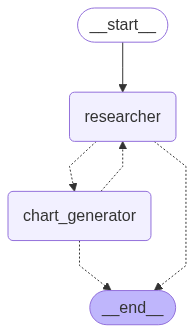

In [30]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [32]:
app.invoke({"messages": [("user","get the India's GDP over the past 3 years,after getting the code,compile it using chart generator, then make a line chart of it.Once you make the chart, finish.")]})

{'messages': [HumanMessage(content="get the India's GDP over the past 3 years,after getting the code,compile it using chart generator, then make a line chart of it.Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='845d8083-e83a-48a9-bfe5-5e109d08eccf'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_iaN5Kvo2QlCEd1nI2g9unkp9', 'function': {'arguments': '{"query":"India GDP data last 3 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 234, 'total_tokens': 258, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_b3f1157249', 'id': 'chatcmpl-BpkoIIR9ojziz6d7NygIUbVR5rarw', 'service_tier': 'default', 'finish_

In [33]:
# PythonREPL.run("""
# python\nimport matplotlib.pyplot as plt\n\nyears = [2021, 2022, 2023]\ngdp = [3.167, 3.353, 3.568]\n\nplt.figure(figsize=(8,5))\nplt.plot(years, gdp, marker=\'o\', linestyle=\'-\', color=\'b\', label=\'GDP\')\nplt.title("India\'s GDP Over the Past 3 Years")\nplt.xlabel(\'Year\')\nplt.ylabel(\'GDP (Trillion USD)\')\nplt.xticks(years)\nplt.grid(True)\nplt.legend()\nplt.tight_layout()\nplt.show()\n
#  """)